In [1]:
import dgl
dgl.__version__

'0.9.0'

In [1]:
from functions_HGPLS import net_graph, train, test, extract_prediction
from graph_networks import HGPSLModel

import numpy as np
import pandas as pd
import scipy.sparse as sp

import dgl
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")

model = AutoModelForMaskedLM.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
atoms = ["", "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm"]
print(len(atoms))
ids = tokenizer(atoms).input_ids

toks = list()
for i in ids:
    if len(i) >= 3:
        toks.append(i[1])
    else:
        toks.append(i[0])

100


In [4]:
dataset, labels_g = dgl.load_graphs("../data/HIV_dgl_graphs")

In [5]:
labels_g = labels_g['glabel'].tolist()

In [6]:
tok = torch.zeros((len(toks), 1))
for i in range(len(toks)):
    tok[i] = toks[i]

tok
transfo_atoms = model(tok.to(torch.long)).logits.reshape(100, -1)

In [7]:
pca = PCA(n_components=100, random_state=42)
res = pca.fit_transform(transfo_atoms.detach().numpy())

In [37]:
new_dataset = list()
for i in tqdm(range(len(dataset))):
    g= dataset[i]
    l = labels_g[i]
    ids=list(g.ndata["atomic"].numpy().flatten().astype(int))
    g.ndata["feature"] = torch.tensor(res[ids])
    g.edata["type"] = g.edata["type"].to(dtype=torch.float32)
    g = dgl.add_self_loop(g)
    g = dgl.add_reverse_edges(g, copy_edata=True)
    # g.nodes["_N"].data["atomic"] = g.nodes["_N"].data["atomic"].to(torch.float32)
    # g.edata["_ID"] = g.edata["_ID"].to(dtype=torch.int64)
    # g.nodes["_N"].data["atomic"] = g.nodes["_N"].data["atomic"].to(torch.int32)
    a=dgl.graph(g.edges(), idtype=torch.int64)
    a.ndata["feature"] = g.ndata["feature"]
    a.edata["type"] = g.edata["type"]
    new_dataset.append((a, l))

100%|██████████| 2443/2443 [00:02<00:00, 866.05it/s]


In [38]:
train_dataset, test_dataset = train_test_split(new_dataset, test_size=0.25, random_state=42)

train_dataloader = GraphDataLoader(train_dataset, batch_size=16, drop_last=False)
test_dataloader = GraphDataLoader(test_dataset, batch_size=16, drop_last=False)

In [45]:
# Load model architecture
device = 'cpu' if torch.cuda.is_available() else 'cpu'
model = HGPSLModel(in_feat=100, out_feat=3, hid_feat=256).to(device)

In [46]:
# Define optimizer and loss
optimizer = torch.optim.Adam(
        model.parameters(), lr=0.0001, #weight_decay=0.001
    )
loss = torch.nn.CrossEntropyLoss()

In [48]:
# Train model and keep the best validation loss model
bad_cound = 0
best_val_acc = 0.5139
best_epoch = 0
epochs = 10
patience = 10
print_every = 1
train_times = []
for e in range(epochs):
    s_time = time()
    train_loss, train_acc = train(model, optimizer, loss, train_dataloader, device)
    train_times.append(time() - s_time)
    val_acc, val_loss = test(model, loss, test_dataloader, device)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        bad_cound = 0
        best_epoch = e + 1
        torch.save(model.state_dict(), "../models/HGPSLModel_red.pt")
    else:
        bad_cound += 1
    if bad_cound >= patience:
        break

    if (e + 1) % print_every == 0:
        log_format = (
            "Epoch {}: train_loss={:.4f}, train_acc={:.4f}, val_acc={:.4f}, vall_loss={:.4f}"
        )
        print(log_format.format(e + 1, train_loss, train_acc, val_acc, val_loss))
print(
    "Best Epoch {}, final test acc {:.4f}".format(
        best_epoch, best_val_acc
    )
)

100%|██████████| 39/39 [00:05<00:00,  7.42it/s]


Epoch 1: train_loss=0.9836, train_acc=0.4842, val_acc=0.5221, vall_loss=0.9177


100%|██████████| 39/39 [00:06<00:00,  5.89it/s]


Epoch 2: train_loss=0.9814, train_acc=0.4924, val_acc=0.5286, vall_loss=0.9184


100%|██████████| 39/39 [00:06<00:00,  6.34it/s]


Epoch 3: train_loss=0.9778, train_acc=0.4940, val_acc=0.5074, vall_loss=0.9130


 27%|██▋       | 31/115 [00:08<00:22,  3.77it/s]

In [ ]:
model.load_state_dict(torch.load("../models/HGPSLModel_red.pt"))

In [ ]:
emb_test=[]
lab_test = []
for batch in tqdm(test_dataloader):
        batch_graphs, batch_labels = batch
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.long().to(device)
        out = model(batch_graphs, batch_graphs.ndata["feature"].to(dtype=torch.float32))
        emb_test += out.tolist()
        lab_test += batch_labels.tolist()

In [ ]:
emb_train=[]
lab_train = []
for batch in tqdm(train_dataloader):
        batch_graphs, batch_labels = batch
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.long().to(device)
        out = model(batch_graphs, batch_graphs.ndata["feature"].to(dtype=torch.float32))
        emb_train += out.tolist()
        lab_train += batch_labels.tolist()

In [ ]:
from xgboost import XGBClassifier
xgb =XGBClassifier(random_state=0)

xgb.fit(emb_train, lab_train)
predxgb = xgb.predict(emb_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(lab_test, predxgb)

In [105]:
pos = [g for (g, l) in dataset if int(l) == 1]
neg = [g for (g, l) in dataset if int(l) == 0]

In [68]:
from collections import Counter
Counter([len(g.nodes()) for g in pos]).keys()

dict_keys([27, 60, 11, 36, 25, 8, 176, 47, 86, 80, 33, 39, 15, 6, 10, 7, 139, 16, 13, 96, 18, 51, 59, 28, 23, 29, 195, 12, 114, 193, 30, 21, 76, 24, 160, 41, 98, 50, 4, 167, 136, 101, 152, 37, 26, 65, 53, 64, 81, 14, 5, 34, 40, 9, 196, 93, 126, 42, 22, 54, 163, 105, 113, 74, 44, 75, 56, 17, 71, 61, 68, 19, 62, 31, 124, 49, 109, 112, 161, 91, 194, 89, 88, 107, 128, 85, 145, 104, 35, 84, 3, 69, 106, 20, 38, 141, 73, 153, 183, 82, 52, 115, 120, 78, 67, 110, 99, 130, 32, 157, 168, 102, 182, 108, 125, 77, 63, 173, 172, 162, 132, 55, 148, 154, 119, 58, 94, 155, 66, 111, 178, 83, 72, 150, 165, 57, 177, 144, 123, 90, 184, 131, 151, 170, 147, 122, 92])

<BarContainer object of 195 artists>

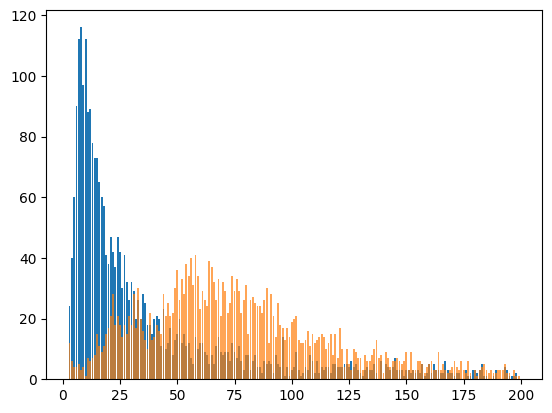

In [106]:
import matplotlib.pyplot as plt
plt.bar(Counter([len(g.nodes()) for g in pos]).keys(), Counter([len(g.nodes()) for g in pos]).values())
plt.bar(Counter([len(g.nodes()) for g in neg]).keys(), Counter([len(g.nodes()) for g in neg]).values(), alpha=0.7)

In [96]:
np.mean([len(g.nodes()) for g in pos]), np.mean([len(g.nodes()) for g in neg])

(38.86639824304539, 76.16361639824305)